In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

from utils.notebook_utils.dataframe_helper import load_candidate_dataframes, mark_sentence

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.learning.pytorch.rnn.utils import candidate_to_tokens
from snorkel.models import Candidate, candidate_subclass

In [4]:
GeneGene = candidate_subclass('GeneGene', ['Gene1', 'Gene2'])

In [5]:
def tag_sentence(x):
    candidates=(
        session
        .query(GeneGene)
        .filter(GeneGene.id.in_(x.candidate_id.astype(int).tolist()))
        .all()
    )
    tagged_sen=[
         " ".join(
             mark_sentence(
                candidate_to_tokens(cand), 
                [
                        (cand[0].get_word_start(), cand[0].get_word_end(), 1),
                        (cand[1].get_word_start(), cand[1].get_word_end(), 2)
                ]
            )
         )
        for cand in candidates
    ]

    return tagged_sen

In [6]:
spreadsheet_names = {
    #'train': '../data/sentences/sentence_labels_train.xlsx',
    'dev': '../data/sentences/sentence_labels_dev.xlsx',
    'test': '../data/sentences/sentence_labels_test.xlsx'
}

In [7]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_gig")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 500
Size of test set: 500


In [8]:
dev_predictions_df = pd.read_table("results/before_28_sampled_lfs.tsv_dev.tsv")
dev_predictions_df.columns = ["model_predictions", "candidate_id"]
dev_predictions_df.head(2)

,model_predictions,candidate_id
0,0.379113,43397
1,0.108290,44812


In [9]:
model_predictions_df = (
    candidate_dfs['dev']
    .merge(dev_predictions_df)
    [["curated_gig", "model_predictions"]]
    .round(2)
)
model_predictions_df.head(2)

,curated_gig,model_predictions
0,0.0,0.38
1,0.0,0.11


In [10]:
dev_all_predictions_df = pd.read_table("results/after_28_sampled_lfs.tsv_dev.tsv")
dev_all_predictions_df.columns = ["candidate_id", "model_predictions"]
dev_all_predictions_df.head(2)

,candidate_id,model_predictions
0,43397,0.477330
1,44812,0.404243


In [11]:
total_candidates_df = pd.read_csv("../dataset_statistics/results/all_gig_candidates.tsv.xz", sep="\t")
total_candidates_df.head(2)

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,gene1_id,gene1_name,gene2_id,gene2_name,sources,n_sentences,hetionet,has_sentence,split,partition_rank,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
0,1,A1BG,10321,CRISP3,II_literature|hetio-dag,5,1,1,3,0.436432,0.0,0.0,2,65570963,Human CRISP-3 binds serum alpha(1)B-glycoprote...,11,20992573
1,1,A1BG,10321,CRISP3,II_literature|hetio-dag,5,1,1,3,0.436432,0.0,0.0,3,65570968,BACKGROUND: CRISP-3 was previously shown to be...,21,20930188


In [12]:
confidence_score_df = (
    total_candidates_df
    [["gene1_name", "gene2_name", "text", "candidate_id"]]
    .merge(dev_all_predictions_df, on="candidate_id")
    .sort_values("candidate_id")
    .assign(text=lambda x: tag_sentence(x))
    .sort_values("model_predictions")
)
confidence_score_df.head(2)

,gene1_name,gene2_name,text,candidate_id,model_predictions
208,NFKB1,TNF,~~[[1 nf-kappab-dependent 1]]~~ reporter gene ...,10651071,0.276318
109,IL2,IFNG,pbl of ms patients produced more pro-inflammat...,3853275,0.282803


In [13]:
(
    confidence_score_df
    .head(10)
    .sort_values("model_predictions", ascending=False)
    .drop("candidate_id", axis=1)
    .round(3)
    .to_csv("results/bottom_ten_high_confidence_scores.tsv", sep="\t", index=False)
)

In [14]:
(
    confidence_score_df
    .tail(10)
    .sort_values("model_predictions", ascending=False)
    .drop("candidate_id", axis=1)
    .round(3)
    .to_csv("results/top_ten_high_confidence_scores.tsv", sep="\t", index=False)
)

In [15]:
model_all_predictions_df = (
    candidate_dfs['dev']
    .merge(dev_all_predictions_df, on="candidate_id")
    [["curated_gig", "model_predictions"]]
    .round(2)
)
model_all_predictions_df.head(2)

,curated_gig,model_predictions
0,0.0,0.48
1,0.0,0.40


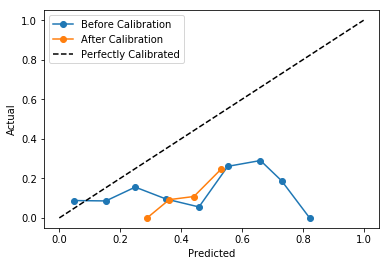

In [16]:
from sklearn.calibration import calibration_curve
cnn_y, cnn_x = calibration_curve(model_predictions_df.curated_gig, model_predictions_df.model_predictions, n_bins=10)
all_cnn_y, all_cnn_x = calibration_curve(model_predictions_df.curated_gig, model_all_predictions_df.model_predictions, n_bins=10)

plt.plot(cnn_x, cnn_y, marker='o', label="Before Calibration")
plt.plot(all_cnn_x, all_cnn_y, marker='o', label="After Calibration")

plt.plot([0,1], [0,1], color='black', linestyle='--', label="Perfectly Calibrated")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.legend()